In [61]:
import os
from datetime import datetime, timezone
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

DATA_PATH = os.path.join("..", "data")

def load_csv(filename, path=DATA_PATH):
    return pd.read_csv(os.path.join(path, filename))

In [49]:
class TimeSeriesPlot:
    def __init__(self, df: pd.DataFrame, target_col:str, prediction_col:str, time_col:str="time"):
        self.df = df.copy(deep=True)
        self.target = target_col
        self.prediction = prediction_col
        self.time = time_col
        self.df['year'] = self.df[self.time].dt.year
        self.df['month'] = self.df[self.time].dt.month
        self.df['day'] = self.df[self.time].dt.day
        self.df['hours'] = self.df[self.time].dt.hour
        self.df["dayofweek"] = self.df[self.time].dt.weekday
        self.df["se"] = self.squared_error()
        self.df["mae"] = self.absolute_error()
        self.df["mape"] = self.absolute_percentage_error()
        
    def squared_error(self):
        return np.power(np.subtract(self.df[self.target], self.df[self.prediction]), 2)
    
    def absolute_error(self):
        return np.abs(np.subtract(self.df[self.target], self.df[self.prediction]))
    
    def absolute_percentage_error(self):
        return np.abs(np.divide(np.subtract(self.df[self.target], self.df[self.prediction]), self.df[self.target])) * 100
    
    def plot_rmse_by_time(self, time:str):
        fig = plt.figure()
        col_map = {"y": "year", "m": "month", "d": "day", "h": "hours",  "wd": "dayofweek"}
        group_by_cols = [col_map[param] for param in time.split("%") if param in col_map.keys()]
        grouped = self.df.groupby(by=group_by_cols)
        mean = grouped["se"].mean()
        group_index = [str(index) for index in mean.index]
        plt.plot(group_index, np.sqrt(mean), label="rmse")
        return fig
        
    def plot_multiple(self, *cols: str):
        fig = plt.figure()
        for col in cols:
            plt.plot(self.df[self.time].values, self.df[col].values, alpha=0.5, label=col)
        plt.legend()
        plt.show()
        return fig
        
    def plot_target_by_time(self, time:str, *targets:str):
        col_map = {"y": "year", "m": "month", "d": "day", "h": "hours",  "wd": "dayofweek"}
        group_by_cols = [col_map[param] for param in time.split("%") if param in col_map.keys()]
        self.df.boxplot(column=[*targets], by=group_by_cols,
                        layout=(targets.__len__(), 1), rot=45, figsize=(5,10), grid=False)
        return plt.gcf()
        
    def plot_target_by_time_band(self, time:str, *targets:str, band:bool=True):
        fig = plt.figure()
        col_map = {"y": "year", "m": "month", "d": "day", "h": "hours",  "wd": "dayofweek"}
        group_by_cols = [col_map[param] for param in time.split("%") if param in col_map.keys()]
        grouped = self.df.groupby(by=group_by_cols)
        for tar in targets:
            mean = grouped[tar].mean()
            std = grouped[tar].std()
            group_index = [str(index) for index in mean.index]
            plt.plot(group_index, mean, label=tar)
            if band:
                plt.fill_between(group_index, mean - 2*std, mean + 2*std, alpha=.5)
        plt.legend()
        return fig

In [2]:
def mean_absolute_percentage_error(actual, forecast):
    return np.mean(np.abs(np.divide(np.subtract(actual, forecast), actual))) * 100

def to_utc_datetime(df, column="time"):
    df[column] = df.apply(lambda row: datetime.strptime(row[column], "%Y-%m-%d %H:%M:%S%z").astimezone(timezone.utc), axis=1)
    return df

def get_price_load():
    e_data = load_csv("energy_dataset.csv")
    return e_data[["time", "price", "price day ahead", "total load actual"]].rename(columns={"price day ahead": "TSO_price_forecast", "total load actual" : "load"})

def add_weather_data(df):
    w_data = load_csv("weather_features.csv").drop(columns=["weather_id", "weather_icon", "temp_min", "temp_max"])
    w_data = w_data.join(other=df.set_index("time"), on="time").drop_duplicates(subset=["time", "city_name"])
    return w_data.reset_index(drop=True)

def add_weather_data_mean(df):
    w_data = load_csv("weather_features.csv").drop(columns=["city_name", "weather_id", "weather_icon", "temp_min", "temp_max"])
    w_data = w_data.groupby(by=["time"]).mean()
    w_data = df.join(other=w_data, on="time").drop_duplicates(subset=["time"])
    return w_data.reset_index(drop=True)

In [8]:
data = to_utc_datetime( add_weather_data_mean(get_price_load()))
data.drop(index=[0], inplace=True)
prediction = to_utc_datetime(load_csv("rnn_prediction.csv"))


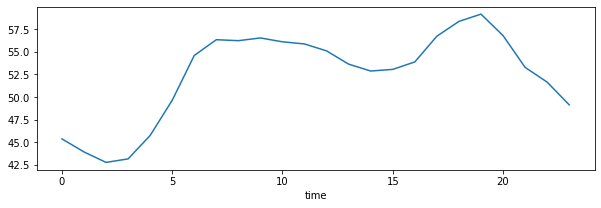

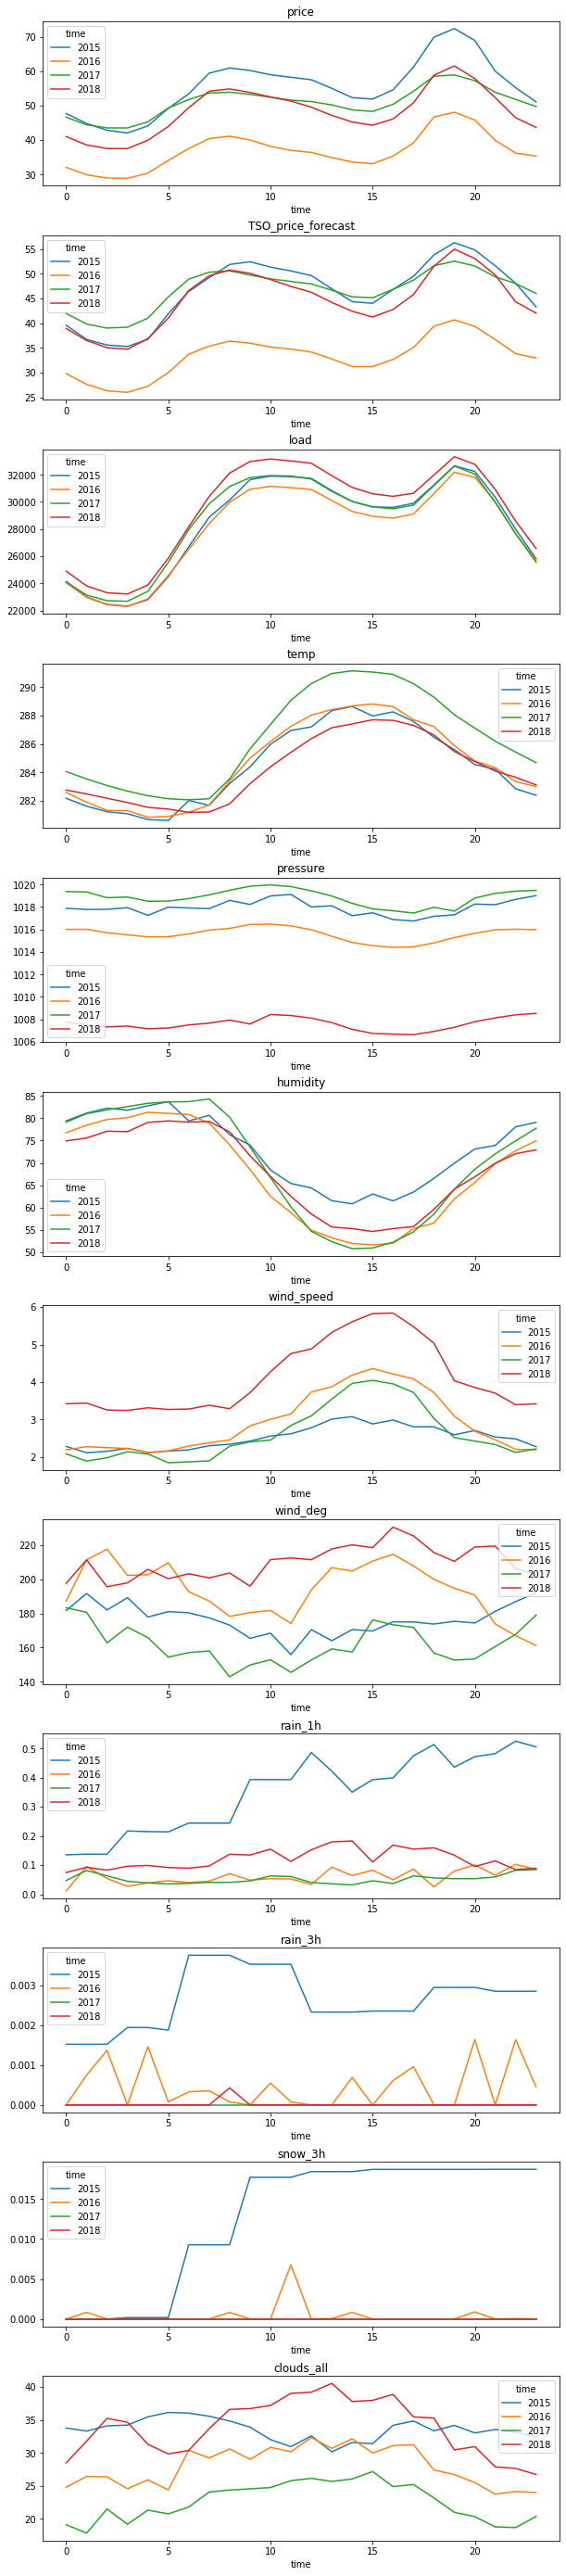

In [45]:
highlight_month = 3
prediction.loc[prediction["time"].dt.month == highlight_month].groupby([prediction["time"].dt.hour]).mean()["prediction"].plot(figsize=(10, 3))
view = data.loc[data["time"].dt.month == highlight_month]
mean = view.groupby([view["time"].dt.hour, view["time"].dt.year]).mean()
n_cols = 1
n_rows = int(np.ceil(len(mean.columns)/n_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10,50))
for (col, ax) in zip(mean.columns, axes.flatten()):
    mean[col].unstack().plot(ax=ax, title=col)
plt.subplots_adjust(hspace=0.3)
plt.show()

,actual,prediction,mae
actual,1.000000,0.369948,0.849069
prediction,0.369948,1.000000,0.006774
mae,0.849069,0.006774,1.000000


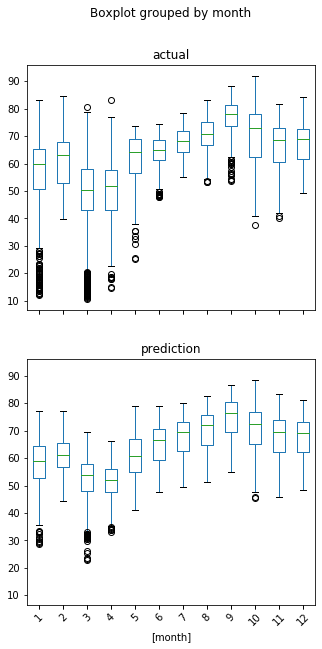

In [58]:
tsp = TimeSeriesPlot(prediction, "actual", "prediction")
plot = tsp.plot_target_by_time("%m", "actual", "prediction")
tsp.df[["time", "actual", "prediction", "mae"]].groupby([tsp.df["time"].dt.month]).agg({"actual": "std", "prediction":"std", "mae": "mean"}).corr()
#n_cols = 1
#n_rows = int(np.ceil(len(grouped)/n_cols))

#fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10,50))
#for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
#    grouped.get_group(key)["prediction"].plot(ax=ax)
#plt.subplots_adjust(hspace=0.3)
#plt.show()

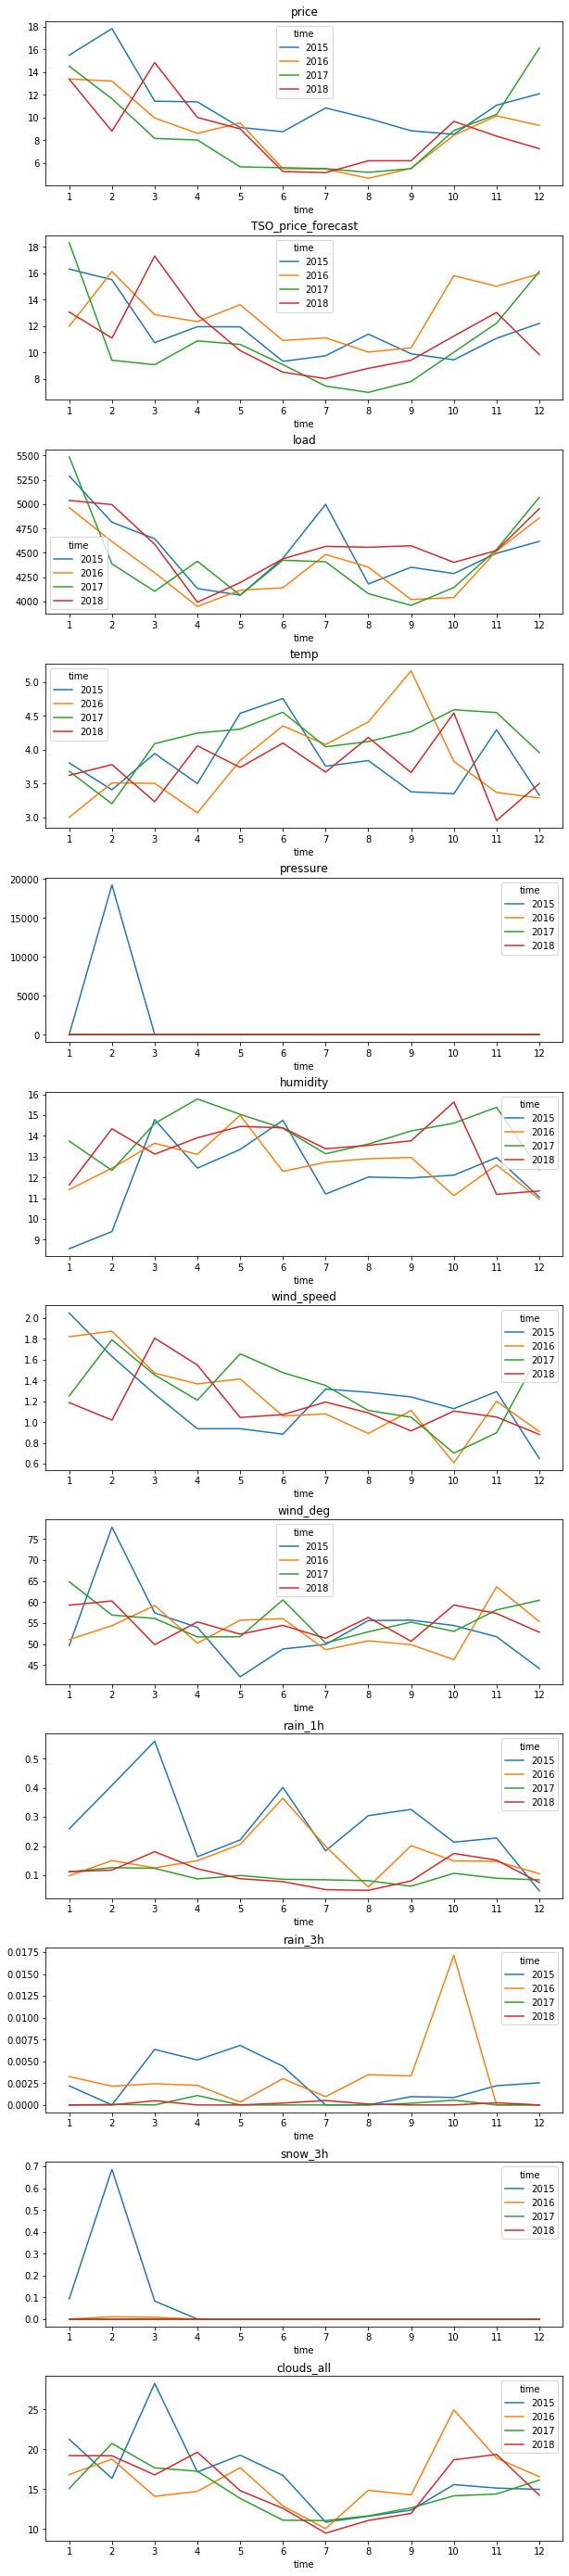

In [55]:
grouped = data.groupby([data["time"].dt.month, data["time"].dt.year]).std()
n_cols = 1
n_rows = int(np.ceil(len(grouped.columns)/n_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10,50))
for (col, ax) in zip(grouped.columns, axes.flatten()):
    grouped[col].unstack().plot(ax=ax, title=col, xticks=range(1,13,1))
plt.subplots_adjust(hspace=0.3)
plt.show()

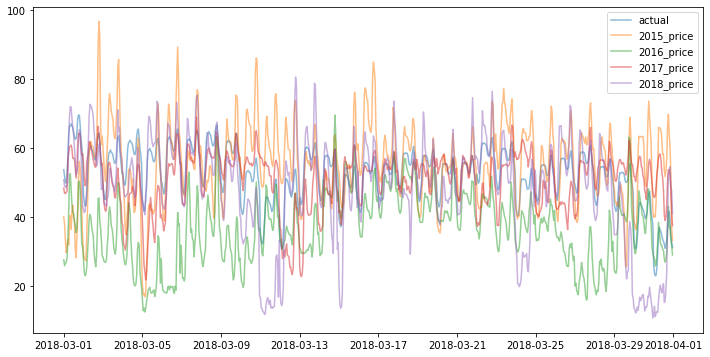

In [84]:
fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
view = tsp.df[tsp.df["time"].dt.month == 3]
plt.plot(view["time"].values, view["prediction"], alpha=0.5, label="actual")
view = data.loc[data["time"].dt.month == 3]
for i in range(2015, 2019, 1):
    year = view.loc[view["time"].dt.year == i].copy(deep=True)
    year["time"] = year["time"].apply(lambda dt: dt.replace(year=2018))
    plt.plot(year["time"].values, year["price"], alpha=0.5, label="%d_price" % i)
plt.legend()
plt.show()